In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 923 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [149]:
import pandas as pd
import numpy as np
import yfinance as yf

sam_stock = yf.download('005930.KS', start='2021-09-30', end='2022-09-30', progress=False)

sam_stock = sam_stock[["Close"]]
sam_stock = sam_stock.reset_index()
sam_stock.columns = ['date', 'price']
sam_stock['date'] = pd.to_datetime(sam_stock['date'])
sam_stock.index = sam_stock['date']
sam_stock.set_index('date', inplace=True)

sam_stock

,price
date,
2021-09-30,74100.0
2021-10-01,73200.0
2021-10-05,72200.0
2021-10-06,71300.0
2021-10-07,71600.0
...,...
2022-09-26,53900.0
2022-09-27,54200.0
2022-09-28,52900.0


In [150]:
sam_stock.shape

(246, 1)

In [151]:
sam_train = sam_stock[:240]
sam_train

,price
date,
2021-09-30,74100.0
2021-10-01,73200.0
2021-10-05,72200.0
2021-10-06,71300.0
2021-10-07,71600.0
...,...
2022-09-16,56200.0
2022-09-19,56400.0
2022-09-20,55800.0


In [152]:
sam_test = sam_stock[240:]
sam_test

,price
date,
2022-09-23,54500.0
2022-09-26,53900.0
2022-09-27,54200.0
2022-09-28,52900.0
2022-09-29,52600.0
2022-09-30,53100.0


In [153]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

model = ARIMA(sam_train.price.values, order = (2,1,2))
model_fit = model.fit(trend = 'c', full_output = True, disp = True)
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  239
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1964.930
Method:                       css-mle   S.D. of innovations            892.503
Date:                Sat, 01 Oct 2022   AIC                           3941.860
Time:                        09:16:29   BIC                           3962.719
Sample:                             1   HQIC                          3950.266
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -71.7079     55.602     -1.290      0.197    -180.685      37.269
ar.L1.D.y      1.7479      0.031     55.641      0.000       1.686       1.809
ar.L2.D.y     -0.9011      0.032    -28.085      0.0

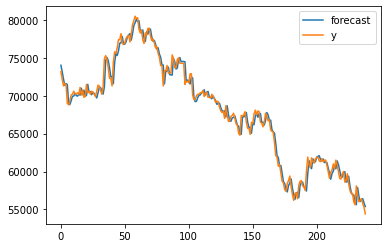

In [154]:
fig = model_fit.plot_predict()

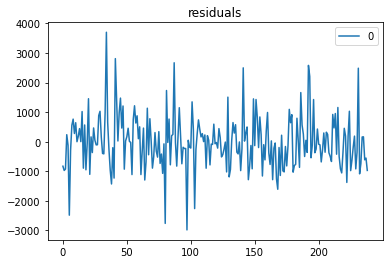

In [155]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title="residuals")
plt.show()

In [156]:
forecast_data = model_fit.forecast(steps=6)
pred_arima_y = forecast_data[0].tolist()

In [ ]:
!pip install prophet

In [157]:
from prophet import Prophet

sam_stock = sam_stock.reset_index()
sam_stock.columns = ['ds', 'y']

sam_train = sam_stock[:240]
sam_test = sam_stock[240:]

In [158]:
prophet = Prophet(seasonality_mode = 'multiplicative', 
                  yearly_seasonality=True, 
                  weekly_seasonality=True, 
                  daily_seasonality=True, 
                  changepoint_prior_scale=0.5)

prophet.fit(sam_train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp78_61klu/x3jlnjt0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp78_61klu/_xbjy5ko.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59254', 'data', 'file=/tmp/tmp78_61klu/x3jlnjt0.json', 'init=/tmp/tmp78_61klu/_xbjy5ko.json', 'output', 'file=/tmp/tmpmg2spv9k/prophet_model-20221001091632.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:16:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:16:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [159]:
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

pred_fbprophet_y = forecast_data.yhat.values[-6:]
test_y = sam_test.y.values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
DEBUG:cmdstanpy:input tempfile: /tmp/tmp78_61klu/ryfje1_j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp78_61klu/oab68xq3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4297', 'data', 'file=/tmp/tmp78_61klu/ryfje1_j.json', 'init=/tmp/tmp78_61klu/oab68xq3.json', 'output', 'file=/tmp/tmp73xjdw8r/prophet_model-20221001091635.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:16:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:16

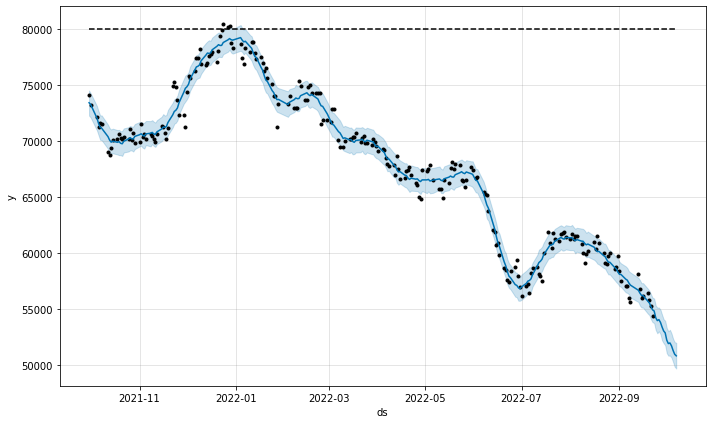

In [160]:
%matplotlib inline
import matplotlib.pyplot as plt

# 상한가 설정
sam_train['cap'] = 80000

# 상한가 적용을 위한 파라미터를 다음과 같이 설정
prophet = Prophet(seasonality_mode = 'multiplicative', growth = 'logistic', 
                  yearly_seasonality = True, weekly_seasonality = True,
                  daily_seasonality = True, changepoint_prior_scale = 0.5)

prophet.fit(sam_train)

future_data = prophet.make_future_dataframe(periods=15, freq='d')

# 상한가 설정
future_data['cap'] = 80000
forecast_data = prophet.predict(future_data)

fig = prophet.plot(forecast_data)

In [161]:
forecast_data

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2021-09-30,73850.824082,80000,72281.385550,74525.008998,73850.824082,73850.824082,0.034566,0.034566,0.034566,...,-0.000170,-0.000170,-0.000170,-0.040043,-0.040043,-0.040043,0.0,0.0,0.0,73433.739226
1,2021-10-01,73822.592133,80000,72122.578836,74279.309327,73822.592133,73822.592133,0.034566,0.034566,0.034566,...,0.002256,0.002256,0.002256,-0.044138,-0.044138,-0.044138,0.0,0.0,0.0,73282.452147
2,2021-10-05,73708.473086,80000,70960.680932,73134.559955,73708.473086,73708.473086,0.034566,0.034566,0.034566,...,0.003180,0.003180,0.003180,-0.060086,-0.060086,-0.060086,0.0,0.0,0.0,72061.850601
3,2021-10-06,73679.643512,80000,70547.858667,72679.440128,73679.643512,73679.643512,0.034566,0.034566,0.034566,...,0.000931,0.000931,0.000931,-0.063735,-0.063735,-0.063735,0.0,0.0,0.0,71599.029075
4,2021-10-07,73650.693213,80000,70126.023380,72302.277429,73650.693213,73650.693213,0.034566,0.034566,0.034566,...,-0.000170,-0.000170,-0.000170,-0.067164,-0.067164,-0.067164,0.0,0.0,0.0,71237.245553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,2022-10-03,52728.903557,80000,50851.080931,53153.273327,52728.903531,52728.903584,0.034566,0.034566,0.034566,...,0.002444,0.002444,0.002444,-0.051284,-0.051284,-0.051284,0.0,0.0,0.0,51976.253463
251,2022-10-04,52639.624469,80000,50667.484683,52828.233725,52639.624437,52639.624502,0.034566,0.034566,0.034566,...,0.003180,0.003180,0.003180,-0.055276,-0.055276,-0.055276,0.0,0.0,0.0,51716.855157
252,2022-10-05,52550.205257,80000,50283.321249,52355.412394,52550.205219,52550.205296,0.034566,0.034566,0.034566,...,0.000931,0.000931,0.000931,-0.059143,-0.059143,-0.059143,0.0,0.0,0.0,51307.565041
253,2022-10-06,52460.646696,80000,49859.515452,52050.961402,52460.646653,52460.646744,0.034566,0.034566,0.034566,...,-0.000170,-0.000170,-0.000170,-0.062842,-0.062842,-0.062842,0.0,0.0,0.0,50968.317750


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
DEBUG:cmdstanpy:input tempfile: /tmp/tmp78_61klu/rbbiislq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp78_61klu/jnheovrb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78452', 'data', 'file=/tmp/tmp78_61klu/rbbiislq.json', 'init=/tmp/tmp78_61klu/jnheovrb.json', 'output', 'file=/tmp/tmpq93xf0p7/prophet_model-20221001091637.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:16:37 - cmdstanpy - INFO - Chain [1] start processing
I

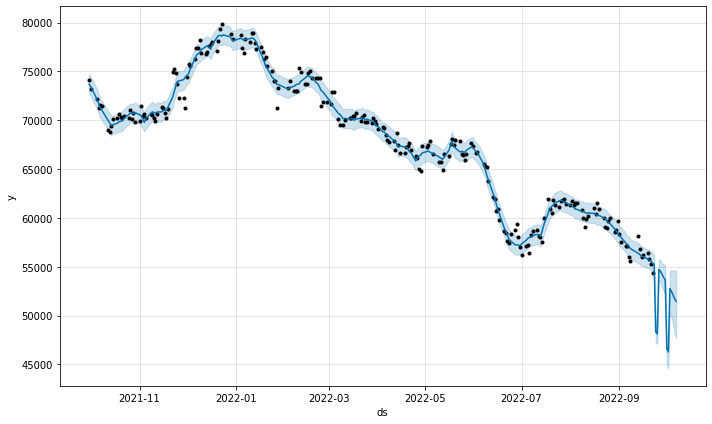

In [162]:
sam_train.loc[sam_train['y'] > 80000, 'y'] = None

# prophet 모델 학습
prophet = Prophet(seasonality_mode = 'multiplicative',
                 yearly_seasonality = True,
                 weekly_seasonality = True,
                 daily_seasonality = True,
                 changepoint_prior_scale = 0.5)

prophet.fit(sam_train)

# 15일 예측 
future_data = prophet.make_future_dataframe(periods = 15, freq = 'd')
forecast_data = prophet.predict(future_data)

fig = prophet.plot(forecast_data)

In [163]:
pred_fbprophet_y_1 = forecast_data.yhat.values[-6:]

In [167]:
df = pd.DataFrame({'날짜': forecast_data.ds[-6:],
                   '예측값': pred_arima_y,
                   '실제값': test_y})

df

,날짜,예측값,실제값
249,2022-10-02,54509.757763,54500.0
250,2022-10-03,54531.129182,53900.0
251,2022-10-04,54458.597547,54200.0
252,2022-10-05,54301.578973,52900.0
253,2022-10-06,54081.502424,52600.0
254,2022-10-07,53827.338100,53100.0
